In [230]:
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

In [231]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [232]:
normal_path = '../data/normal/All/'
abnormal_path = '../data/abnormal/All/'

In [233]:
# 길이 조정 함수
def length_scaling(data, target_length=1024):
    current_length = data.shape[0]
    scaling_factor = target_length / current_length
    scaled_data = np.zeros((target_length, data.shape[1]))


    for i in range(data.shape[1]):
        scaled_data[:, i] = np.interp(
            np.linspace(0, 1, target_length),
            np.linspace(0, 1, current_length),
            data[:, i]
        )

    return scaled_data


def df_rename(df):
    CM_list = ['CM7', 'CM8', 'CM9']
    
    for CM in CM_list:
        # 컬럼명 변경
        new_columns = {
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_FP': 'FP',
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_CP': 'CP',
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_FT': 'Temperature',
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.CAST_OUT_ACTION_TO_PQ_VAL': 'Cast'}
        df = df.rename(columns=new_columns)
    
    return df

def df_normalize(df):
    normalized_df = (df - df.min()) / (df.max() - df.min())
    return normalized_df

In [234]:
def make_df(path):
    cols = ['FP', 'CP', 'Temperature', 'Cast']
    df = []
    
    # 경로 내의 파일 및 폴더 확인
    for root, dirs, files in os.walk(path):
        # 확장자 .csv인 파일 선택
        csv_files = [file for file in files if file.endswith(".csv")]
        
        # csv 파일 처리
        for file in csv_files:
            file_path = os.path.join(root, file)
            
            # CSV 파일 읽고 추가
            csv_data = pd.read_csv(file_path)
            csv_data = df_rename(csv_data)
            csv_data = csv_data[cols].interpolate(method='linear') # 선형 보간
            csv_data = csv_data.dropna(axis=0).reset_index(drop=True)
            csv_data = df_normalize(csv_data)


            df.append(csv_data)
    
    # Pandas DataFrame => NumPy
    df_array = np.array([length_scaling(dataframe.values, 256) for dataframe in df])
        
    return df_array


normal_df = make_df(normal_path)
abnormal_df = make_df(abnormal_path)    

In [235]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(LSTMAutoEncoder, self).__init__()
        self.device = device
        self.encoder = Encoder(num_layers, hidden_size, nb_feature, dropout, device)
        self.decoder = Decoder(num_layers, hidden_size, nb_feature, dropout, device)

    def forward(self, input_seq):
        output = torch.zeros(size=input_seq.shape, dtype=torch.float)
        hidden_cell = self.encoder(input_seq)
        input_decoder = input_seq[:, -1, :].view(input_seq.shape[0], 1, input_seq.shape[2])
        for i in range(input_seq.shape[1] - 1, -1, -1):
            output_decoder, hidden_cell = self.decoder(input_decoder, hidden_cell)
            input_decoder = output_decoder
            output[:, i, :] = output_decoder[:, 0, :]
        return output


class Encoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout, device):
        super(Encoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)

    def initHidden(self, batch_size):
        self.hidden_cell = (
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device),
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device)
        )

    def forward(self, input_seq):
        self.initHidden(input_seq.shape[0])
        _, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.hidden_cell


class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout, device):
        super(Decoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=nb_feature)

    def forward(self, input_seq, hidden_cell):
        output, hidden_cell = self.lstm(input_seq, hidden_cell)
        output = self.linear(output)
        return output, hidden_cell

In [236]:
def create_dataset(df):
    temp = df.tolist()
    dataset = [torch.tensor(s).float() for s in temp]
    
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    return dataset, seq_len, n_features

In [237]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.1,
  random_state=1209
)

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_dataset, _, _ = create_dataset(abnormal_df)

# loss
criterion = torch.nn.MSELoss()

# 모델 불러오고 Inference

In [238]:
hidden_size = 32
num_layers = 4
model_best = LSTMAutoEncoder(num_layers, hidden_size, n_features, device=device)
checkpoint = torch.load('../model/lstm_32_4_(len256)_epoch_285')
model_best.load_state_dict(checkpoint['model_state_dict'])

model_best.to(device)
model_best.eval()

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(4, 32, num_layers=4, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(4, 32, num_layers=4, batch_first=True)
    (linear): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [239]:
print(len(val_dataset), len(test_dataset))

737 50


In [240]:
# ============= Normal =========================
val_anomalies=0
val_nomal = len(val_dataset)
val_loss = []

with torch.no_grad():
    for data in val_dataset:
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        val_loss.append(loss.cpu().numpy())
        #if loss > threshold:
        
# ============= AbNormal =========================
test_loss = []

with torch.no_grad():
    for data in test_dataset:
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        test_loss.append(loss.cpu().numpy())
        #if loss > threshold:

In [251]:
threshold = 0.062
val_anomal = 0
test_anomal = 0

for loss in val_loss:
    if loss > threshold:
        val_anomal +=1
        
for loss in test_loss:
    if loss > threshold:
        test_anomal +=1
        
print(f'validataion anomal = {val_anomal}')
print(f'test anomal = {test_anomal}')

validataion anomal = 105
test anomal = 47


In [252]:
TP = test_anomal
FP = val_anomal

TN = len(val_dataset)-val_anomal
FN = len(test_dataset)-test_anomal

Accuracy = (TP+TN) / (TP+FP+TN+FN)

precision = TP / (TP+FP)
recall = TP / (TP+FN)
F1 = 2 / (1/precision + 1/recall)

print(f'Accuracy // Precision // Recall // F1-Score')
print(f'{Accuracy} // {precision} // {recall} // {F1}')

Accuracy // Precision // Recall // F1-Score
0.8627700127064803 // 0.3092105263157895 // 0.94 // 0.4653465346534654


# 시각화

In [253]:
# 정규화해서 먼저 나타내봄
all_loss = val_loss + test_loss # 전체 loss
all_loss = np.array(all_loss)
mean = np.mean(all_loss, axis=0)
std = np.std(all_loss)

In [254]:
threshold = 0.1

In [255]:
## Anomaly score로 변환할 거임
class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        self.mean = mean
        self.std = std
    
    def __call__(self, recons_error:np.array):
        x = (recons_error-self.mean)
        return x / self.std

## 비정상 점수 계산기
anomaly_calculator = Anomaly_Calculator(mean, std)

In [256]:
## Anomaly Score
anomaly_scores = []
for temp_loss in all_loss:
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = pd.DataFrame({'Reconstruction Error': all_loss,
                                'Anomaly Score': anomaly_scores})
visualization_df.head()

,Reconstruction Error,Anomaly Score
0,0.022355,-1.060055
1,0.025160,-0.923360
2,0.020279,-1.161228
3,0.045518,0.068942
4,0.051973,0.383574


In [257]:
def label_anomaly(row):
    if row['Reconstruction Error'] > threshold:
        return 'Anomaly'
    else:
        return 'Normal'
    
def label_color(row):
    if row['Reconstruction Error'] > threshold:
        return 'Red'
    else:
        return 'Blue'

visualization_df['Label'] = visualization_df.apply(label_anomaly, axis=1)

visualization_df

,Reconstruction Error,Anomaly Score,Label
0,0.022355,-1.060055,Normal
1,0.025160,-0.923360,Normal
2,0.020279,-1.161228,Normal
3,0.045518,0.068942,Normal
4,0.051973,0.383574,Normal
...,...,...,...
782,0.092601,2.363894,Normal
783,0.089829,2.228783,Normal
784,0.083448,1.917753,Normal
785,0.075208,1.516110,Normal


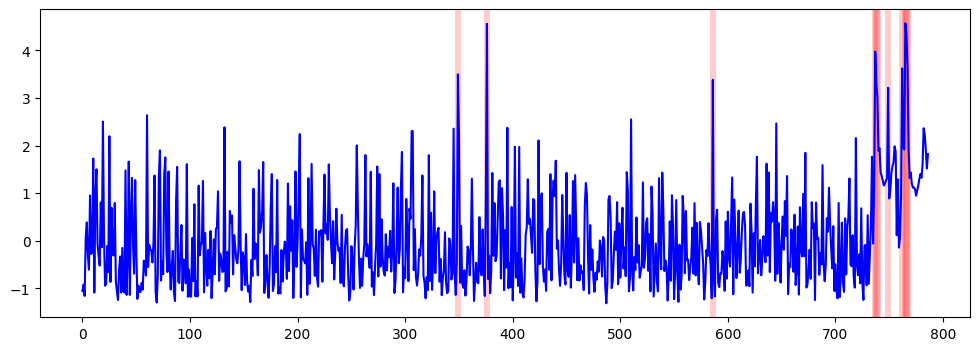

In [262]:
plt.figure(figsize=(12, 4))
plt.plot(visualization_df['Anomaly Score'], color='blue')

# Anomaly인 경우의 구간을 색상으로 표시
anomaly_indices = visualization_df[visualization_df['Label'] == 'Anomaly'].index
for i in anomaly_indices:
    plt.axvspan(i-3, i+3, facecolor='red', alpha=0.2)

## Set1

In [319]:
threshold = 0.063
def label_anomaly(row):
    if row['Reconstruction Error'] > threshold:
        return 'Anomaly'
    else:
        return 'Normal'
    
def label_color(row):
    if row['Reconstruction Error'] > threshold:
        return 'Red'
    else:
        return 'Blue'

In [320]:
set1_path = '../data/Inference/Set1'
set1_df = make_df(set1_path)
set1_dataset, _, _= create_dataset(set1_df)

In [321]:
set1_loss = []

with torch.no_grad():
    for data in set1_dataset:
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        set1_loss.append(loss.cpu().numpy())
        #if loss > threshold:

In [322]:
## Anomaly Score
anomaly_scores = []
for temp_loss in set1_loss:
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = pd.DataFrame({'Reconstruction Error': set1_loss,
                                'Anomaly Score': anomaly_scores})

visualization_df['Label'] = visualization_df.apply(label_anomaly, axis=1)

visualization_df.head()

,Reconstruction Error,Anomaly Score,Label
0,0.06371549,0.955940,Anomaly
1,0.10152817,2.799014,Anomaly
2,0.10349821,2.895038,Anomaly
3,0.111109,3.266005,Anomaly
4,0.112251475,3.321692,Anomaly


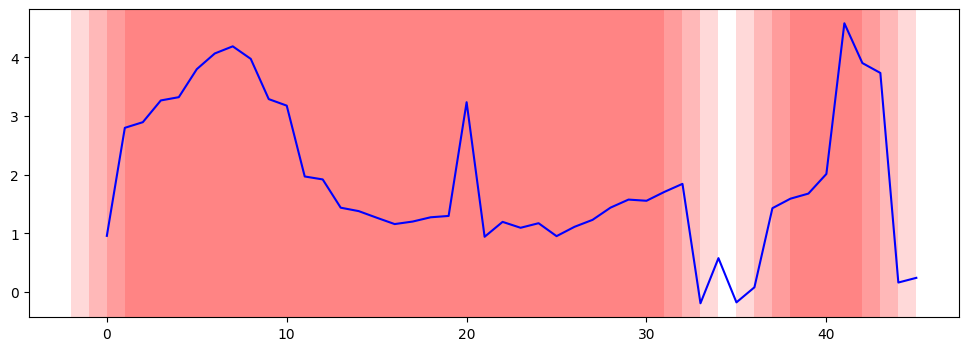

In [323]:
plt.figure(figsize=(12, 4))
plt.plot(visualization_df['Anomaly Score'], color='blue')

# Anomaly인 경우의 구간을 색상으로 표시
anomaly_indices = visualization_df[visualization_df['Label'] == 'Anomaly'].index
for i in anomaly_indices:
    plt.axvspan(i-2, i+2, facecolor='red', alpha=0.15)

## Set2

In [273]:
set2_path = '../data/Inference/Set2'
set2_df = make_df(set2_path)
set2_dataset, _, _= create_dataset(set2_df)

In [326]:
threshold = 0.063
def label_anomaly(row):
    if row['Reconstruction Error'] > threshold:
        return 'Anomaly'
    else:
        return 'Normal'
    
def label_color(row):
    if row['Reconstruction Error'] > threshold:
        return 'Red'
    else:
        return 'Blue'

In [315]:
set2_loss = []

with torch.no_grad():
    for data in set2_dataset:
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        set2_loss.append(loss.cpu().numpy())
        #if loss > threshold:

In [316]:
## Anomaly Score
anomaly_scores = []
for temp_loss in set2_loss:
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = pd.DataFrame({'Reconstruction Error': set2_loss,
                                'Anomaly Score': anomaly_scores})

visualization_df['Label'] = visualization_df.apply(label_anomaly, axis=1)

visualization_df.head()

,Reconstruction Error,Anomaly Score,Label
0,0.04356248,-0.026363,Normal
1,0.035209425,-0.433509,Normal
2,0.043787293,-0.015405,Normal
3,0.03790828,-0.301961,Normal
4,0.038092665,-0.292974,Normal


In [317]:
visualization_df

,Reconstruction Error,Anomaly Score,Label
0,0.04356248,-0.026363,Normal
1,0.035209425,-0.433509,Normal
2,0.043787293,-0.015405,Normal
3,0.03790828,-0.301961,Normal
4,0.038092665,-0.292974,Normal
5,0.039516196,-0.223588,Normal
6,0.0379563,-0.299620,Normal
7,0.037015337,-0.345485,Normal
8,0.08435456,1.961934,Anomaly
9,0.08157842,1.826619,Anomaly


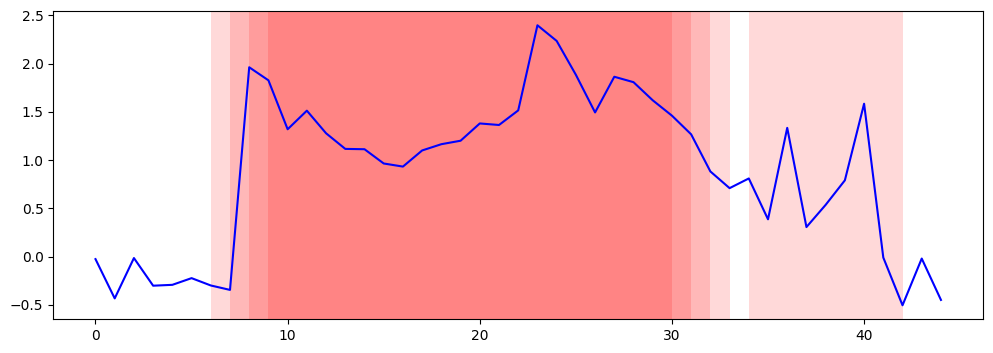

In [318]:
plt.figure(figsize=(12, 4))
plt.plot(visualization_df['Anomaly Score'], color='blue')

# Anomaly인 경우의 구간을 색상으로 표시
anomaly_indices = visualization_df[visualization_df['Label'] == 'Anomaly'].index
for i in anomaly_indices:
    plt.axvspan(i-2, i+2, facecolor='red', alpha=0.15)

## Set3

In [324]:
set3_path = '../data/Inference/Set3'
set3_df = make_df(set3_path)
set3_dataset, _, _= create_dataset(set3_df)

In [327]:
threshold = 0.063
def label_anomaly(row):
    if row['Reconstruction Error'] > threshold:
        return 'Anomaly'
    else:
        return 'Normal'
    
def label_color(row):
    if row['Reconstruction Error'] > threshold:
        return 'Red'
    else:
        return 'Blue'

In [328]:
set3_loss = []

with torch.no_grad():
    for data in set3_dataset:
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        set3_loss.append(loss.cpu().numpy())
        #if loss > threshold:

In [329]:
## Anomaly Score
anomaly_scores = []
for temp_loss in set3_loss:
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = pd.DataFrame({'Reconstruction Error': set3_loss,
                                'Anomaly Score': anomaly_scores})

visualization_df['Label'] = visualization_df.apply(label_anomaly, axis=1)

visualization_df.head()

,Reconstruction Error,Anomaly Score,Label
0,0.043797113,-0.014926,Normal
1,0.03756015,-0.318930,Normal
2,0.04056272,-0.172578,Normal
3,0.039128575,-0.242481,Normal
4,0.04047387,-0.176908,Normal


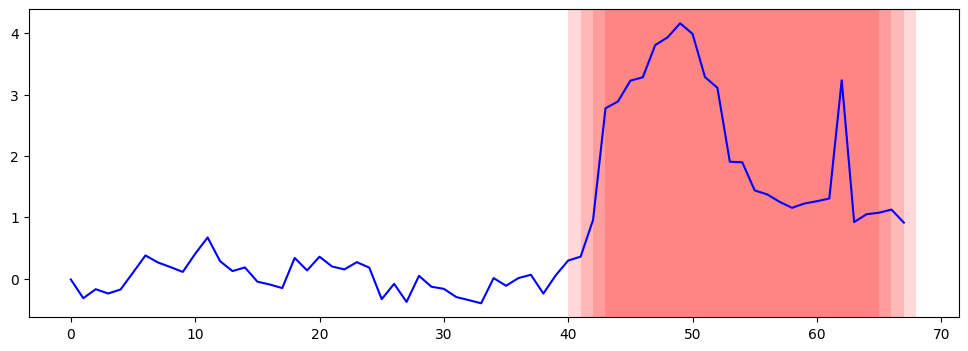

In [330]:
plt.figure(figsize=(12, 4))
plt.plot(visualization_df['Anomaly Score'], color='blue')

# Anomaly인 경우의 구간을 색상으로 표시
anomaly_indices = visualization_df[visualization_df['Label'] == 'Anomaly'].index
for i in anomaly_indices:
    plt.axvspan(i-2, i+2, facecolor='red', alpha=0.15)

In [331]:
len(set3_df)

68

In [332]:
len(visualization_df)

    

68

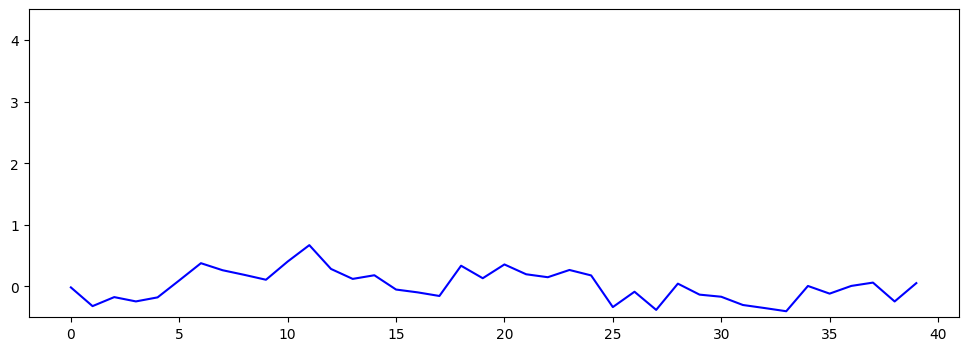

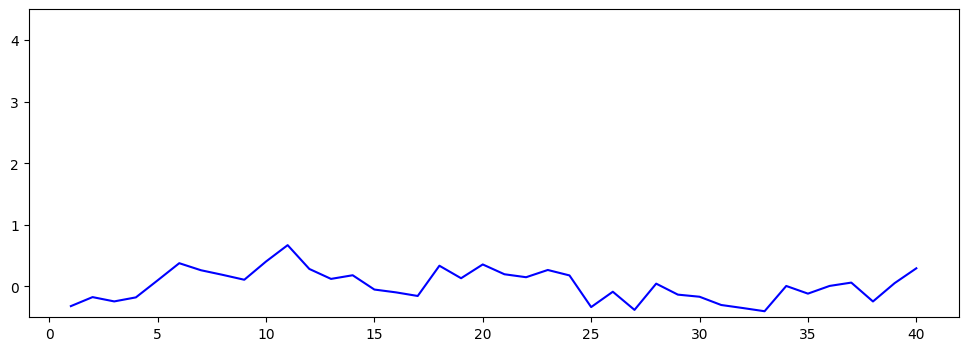

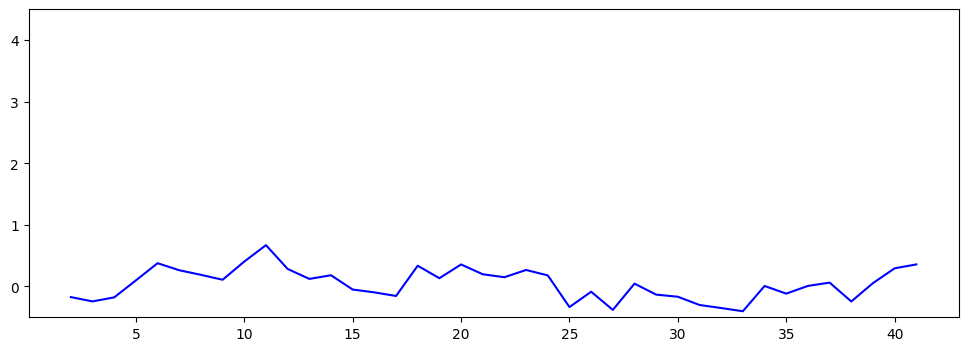

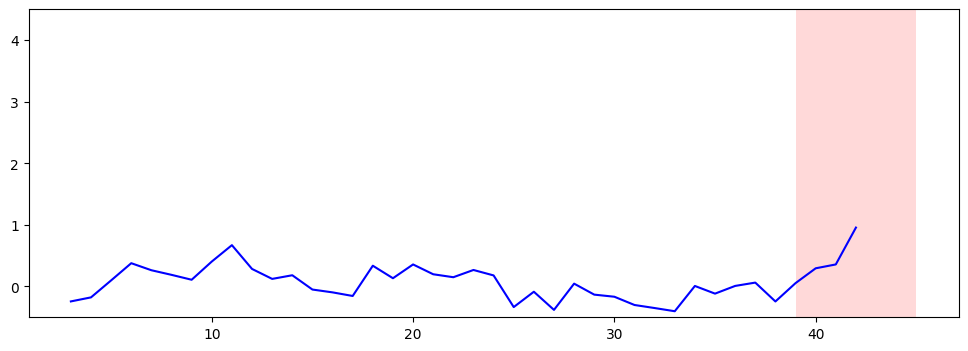

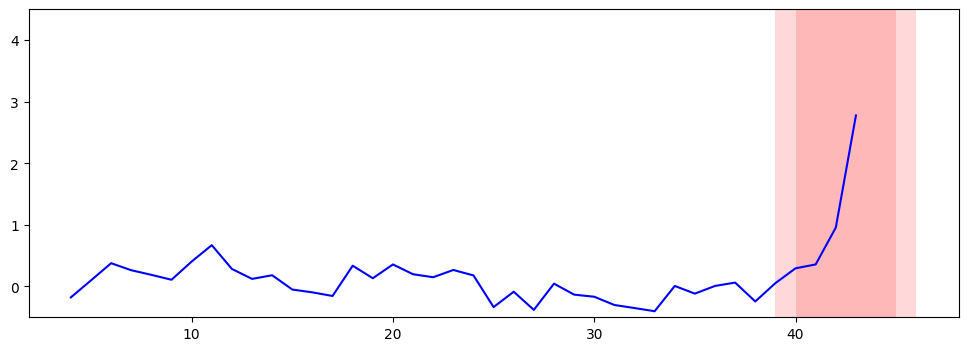

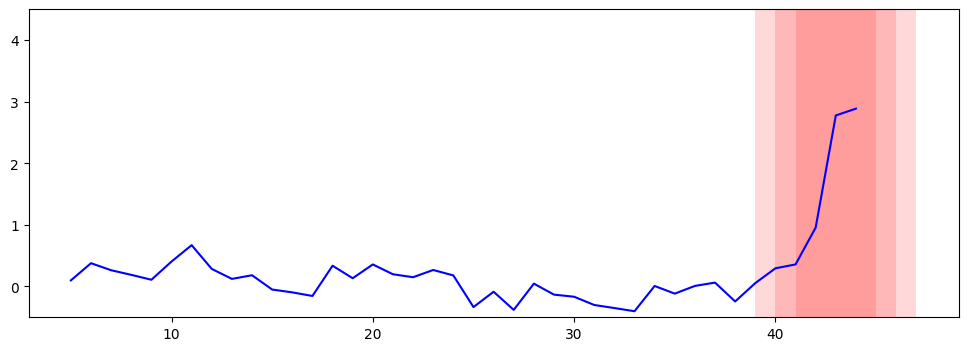

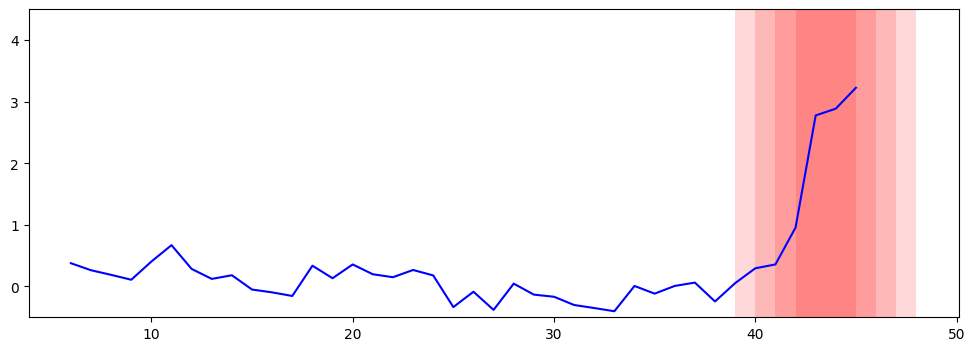

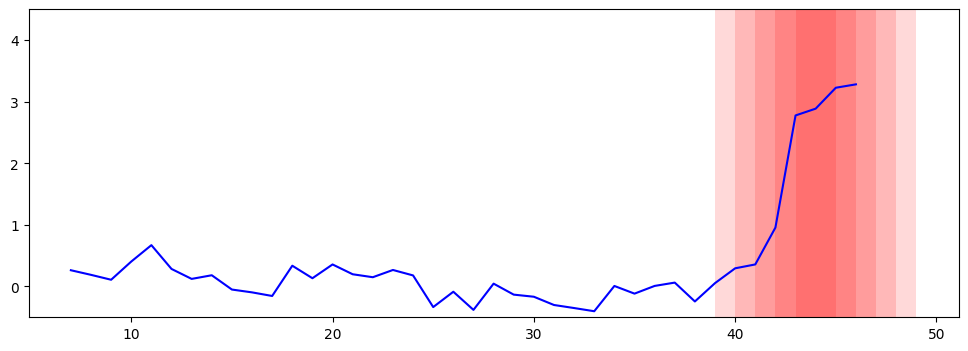

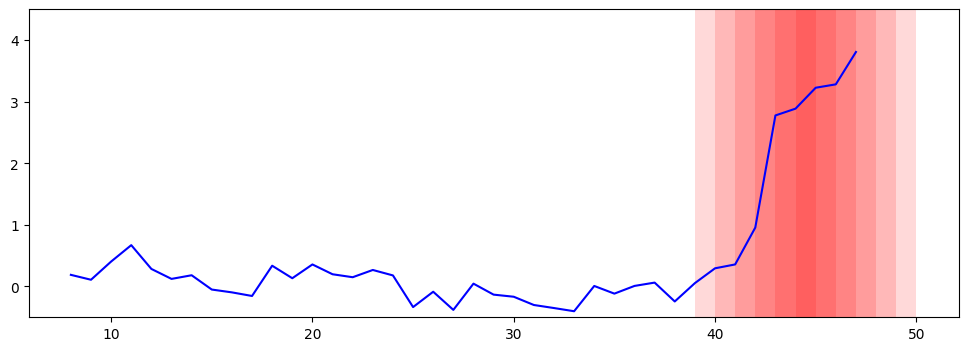

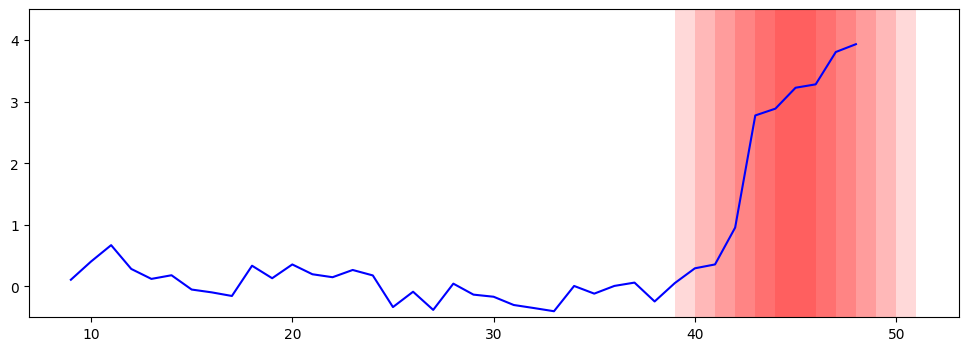

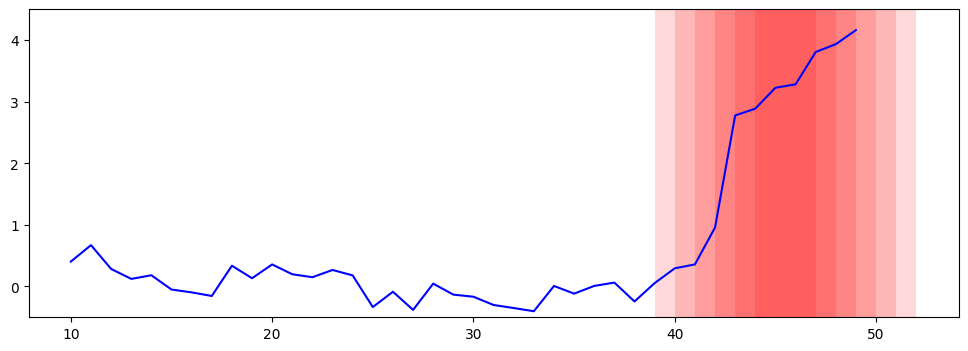

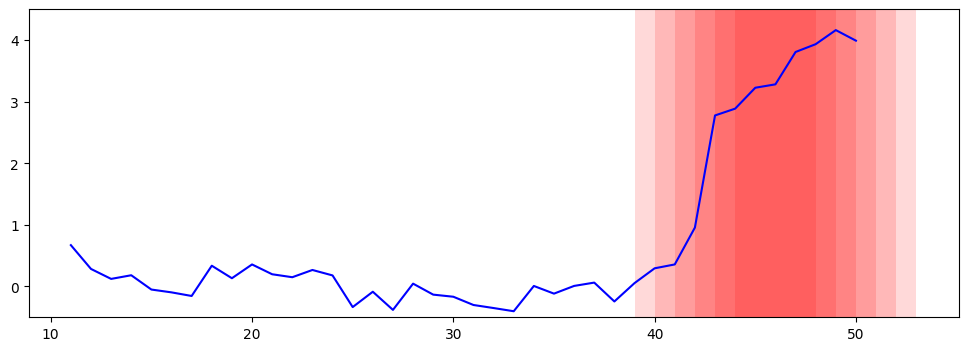

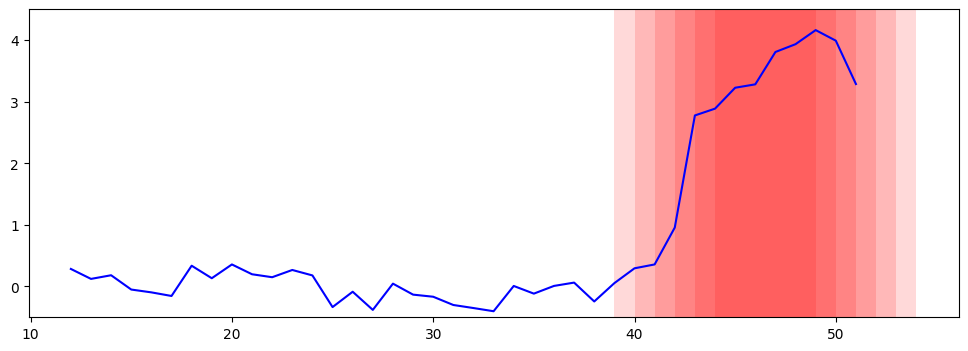

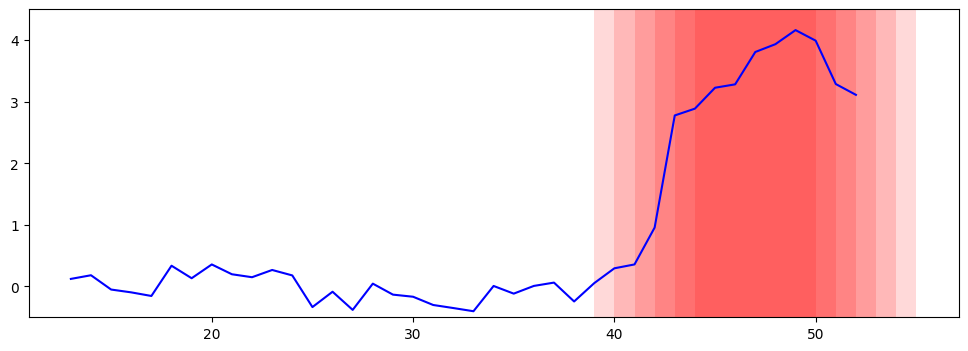

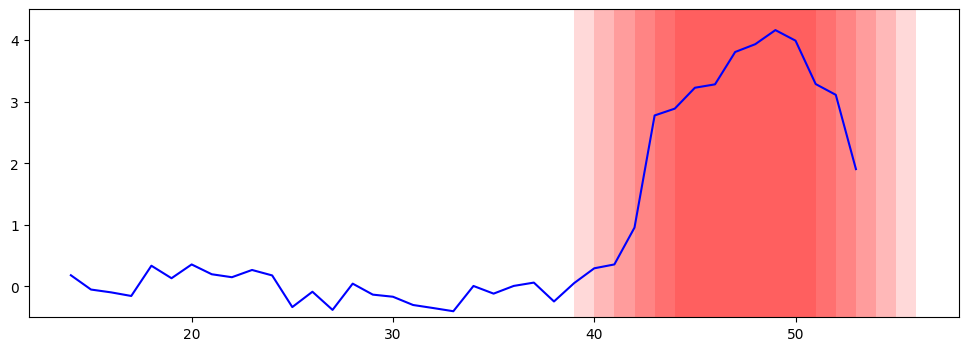

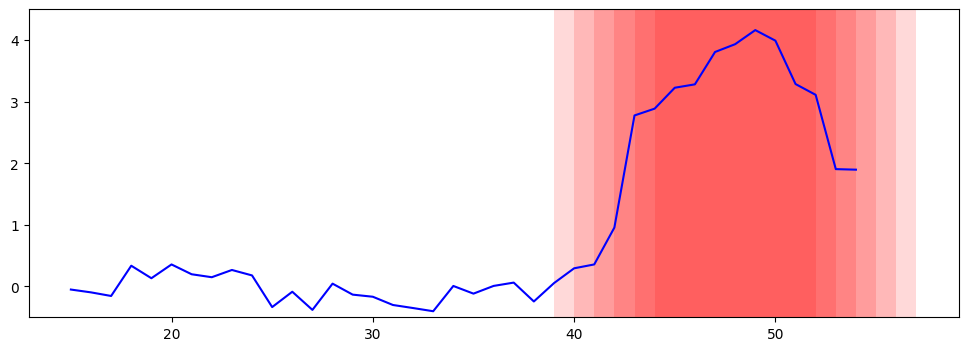

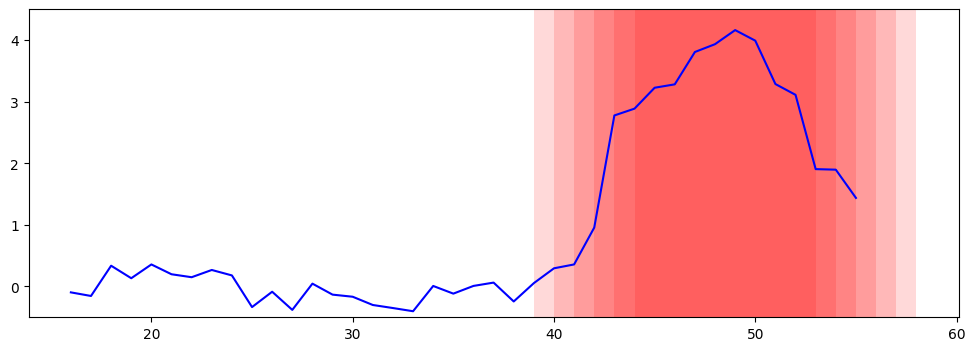

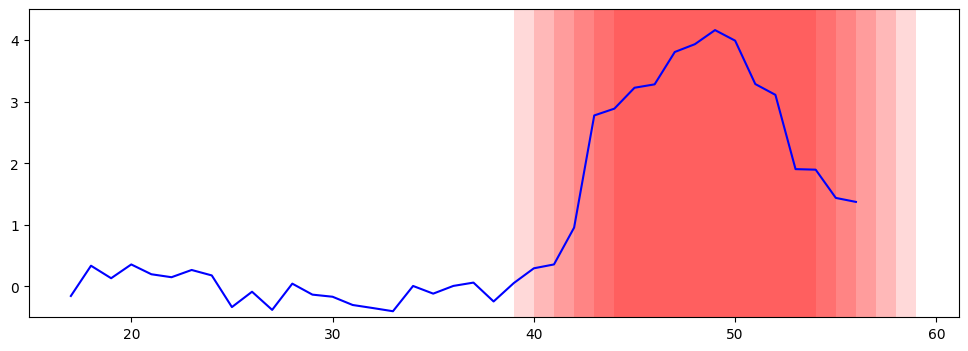

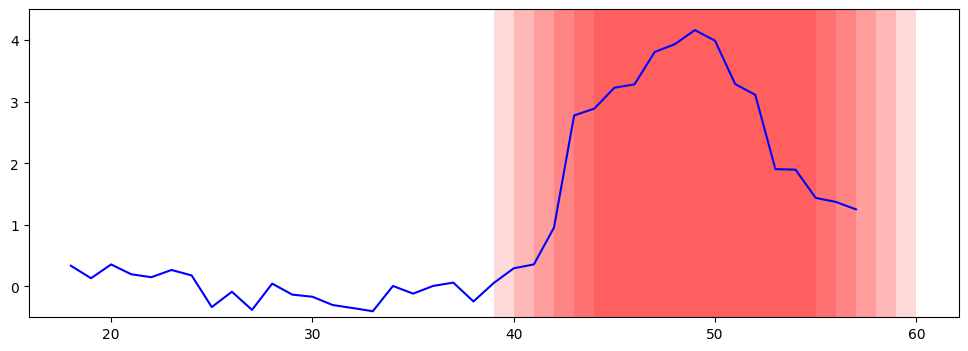

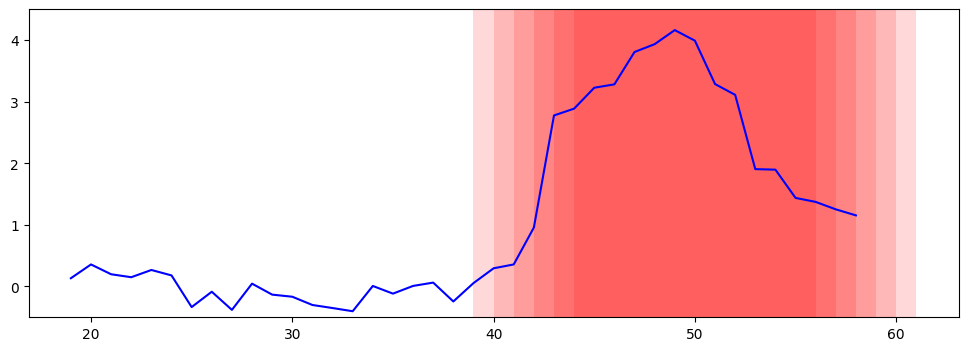

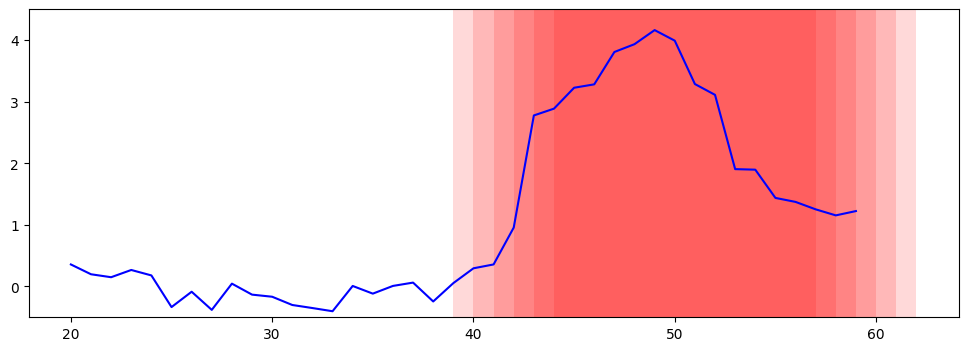

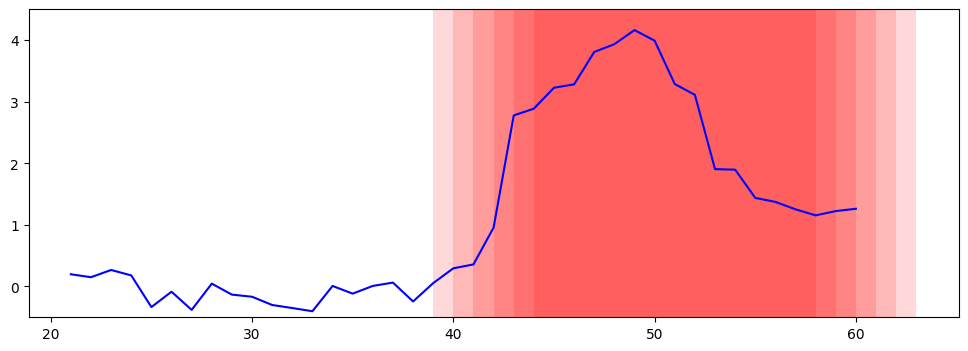

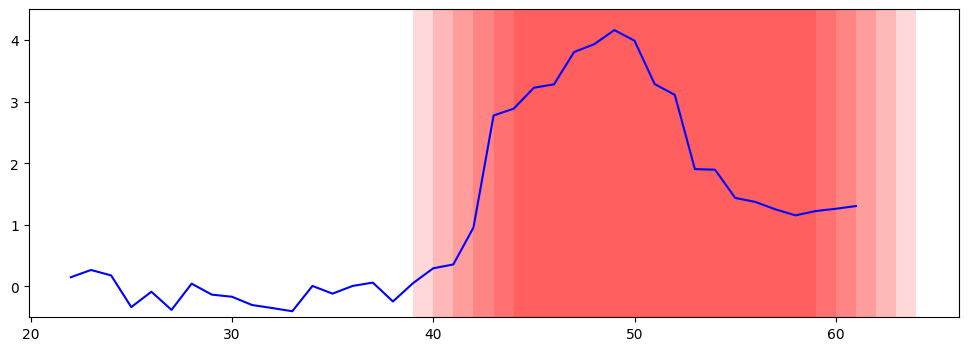

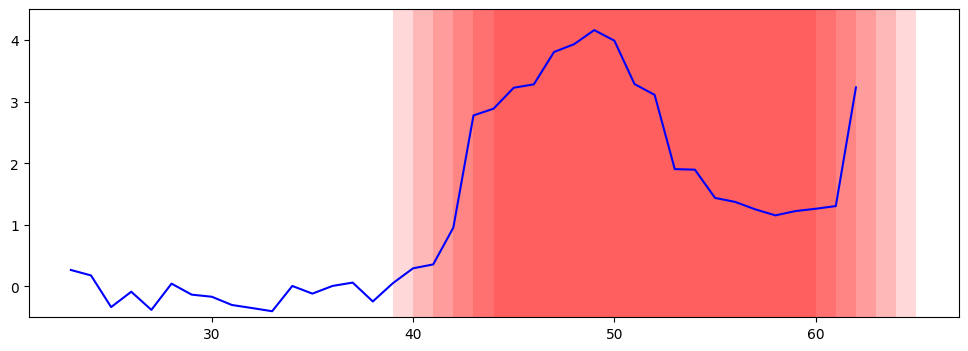

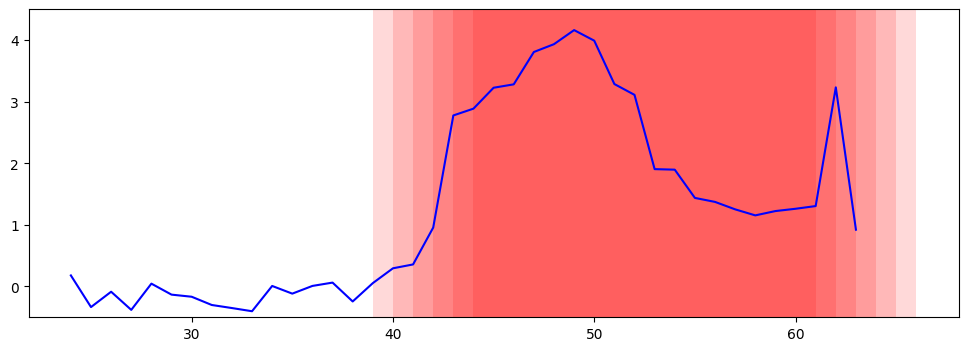

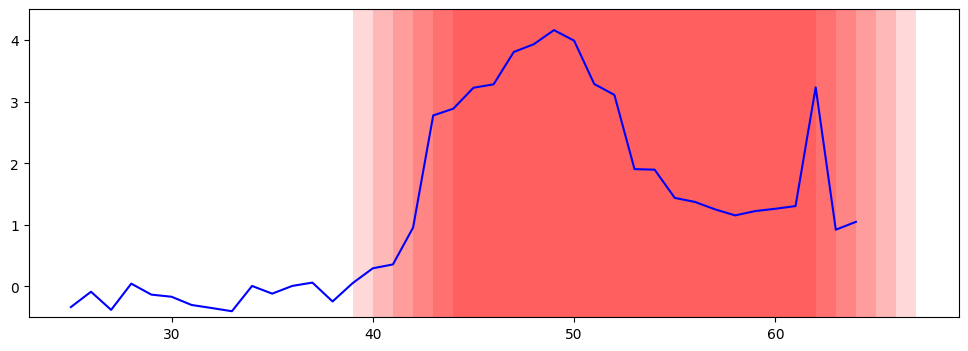

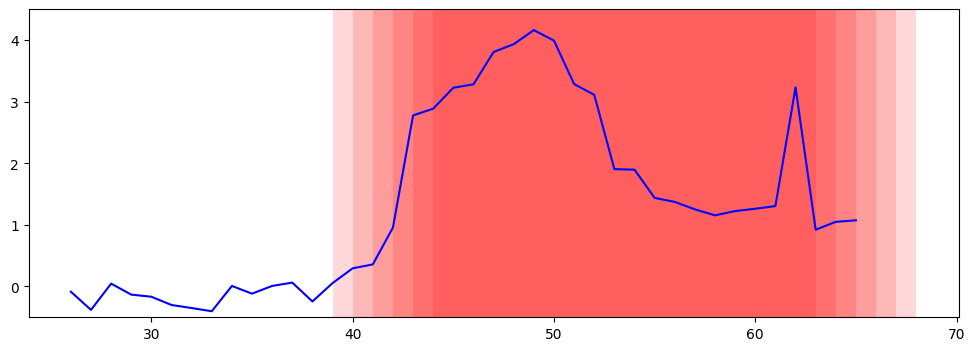

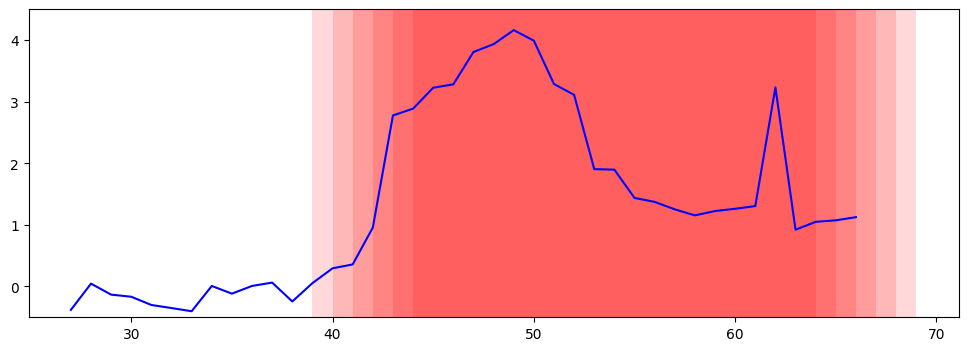

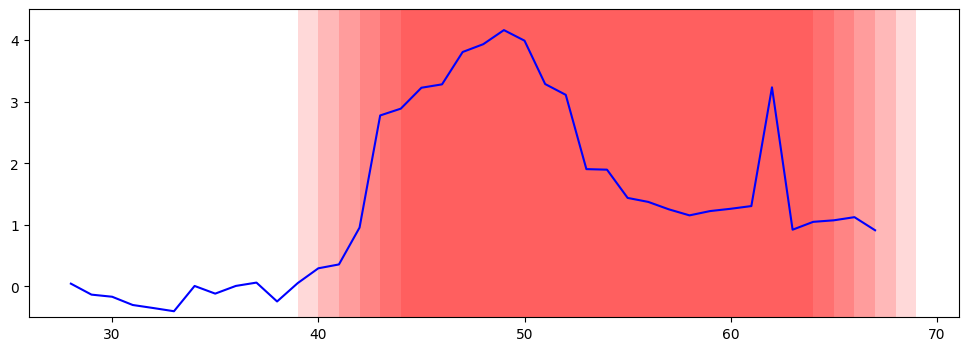

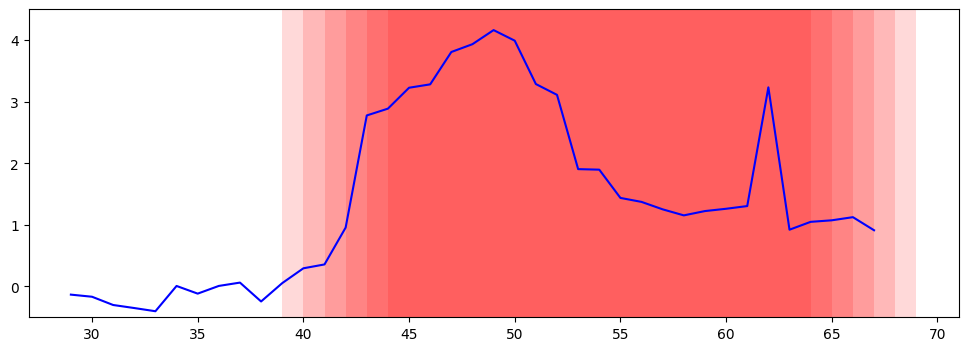

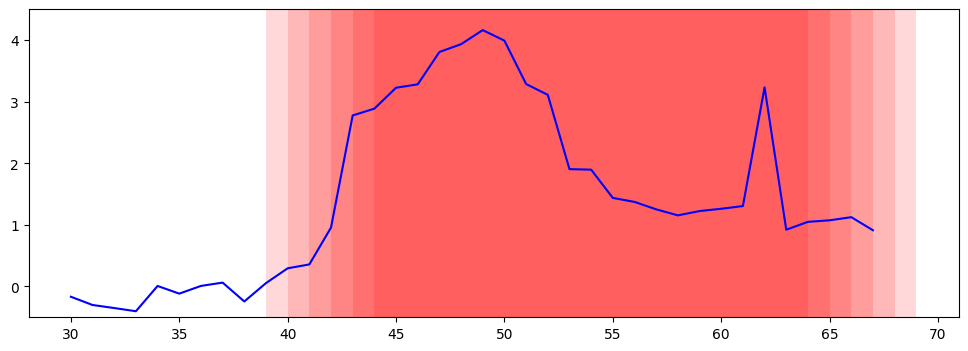

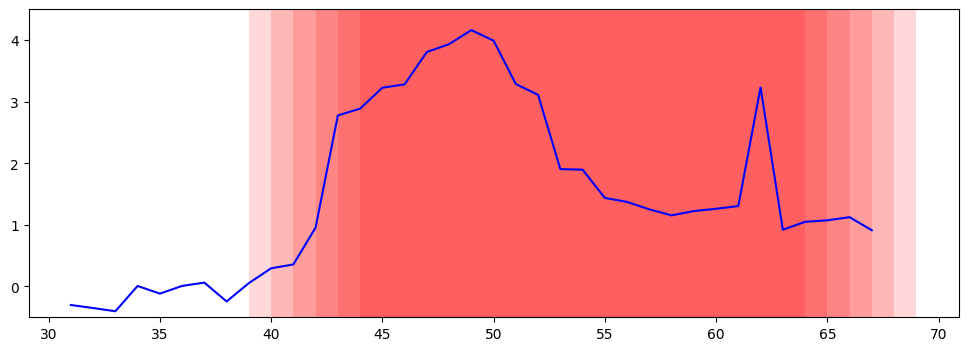

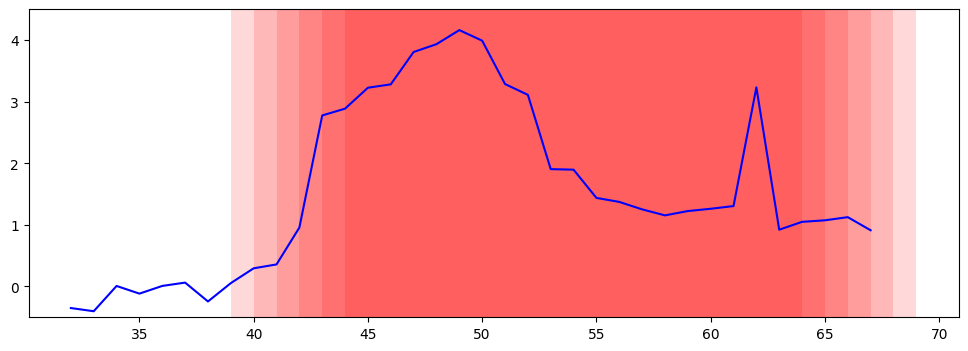

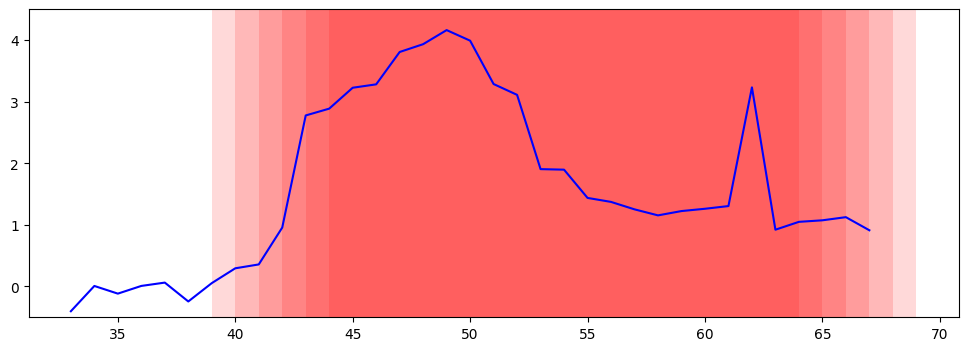

In [353]:
for idx in range(0,34):
    temp_df = visualization_df.iloc[idx:idx+40]
    plt.figure(figsize=(12, 4))
    plt.ylim([-0.5, 4.5])     # Y축의 범위: [ymin, ymax]
    plt.plot(temp_df['Anomaly Score'], color='blue')

    # Anomaly인 경우의 구간을 색상으로 표시
    anomaly_indices = temp_df[temp_df['Label'] == 'Anomaly'].index
    for i in anomaly_indices:
        plt.axvspan(i-3, i+3, facecolor='red', alpha=0.15)
        
    save_path = '../result/img/' + str(idx) +'.png'
    plt.savefig(save_path)
    plt.show()

In [345]:
temp_df

,Reconstruction Error,Anomaly Score,Label
33,0.035858057,-0.401893,Normal
34,0.044275552,0.008394,Normal
35,0.041721016,-0.116120,Normal
36,0.044287756,0.008989,Normal
37,0.0453953,0.062973,Normal
38,0.03911079,-0.243348,Normal
39,0.04522148,0.054501,Normal
40,0.050157018,0.295070,Normal
41,0.051445674,0.357882,Normal
42,0.06372163,0.956239,Anomaly
